<a href="https://colab.research.google.com/github/Gculi/SmartBugPredictor/blob/main/SmartBugPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lightgbm scikit-learn pandas matplotlib seaborn radon pydriller


In [2]:
!git clone https://github.com/pallets/flask.git


fatal: destination path 'flask' already exists and is not an empty directory.


In [4]:
!pip uninstall -y pydriller
!pip install pydriller==2.5


Found existing installation: PyDriller 2.9
Uninstalling PyDriller-2.9:
  Successfully uninstalled PyDriller-2.9
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: gitpython
    Found existing installation: GitPython 3.1.45
    Uninstalling GitPython-3.1.45:
      Successfully uninstalled GitPython-3.1.45


In [9]:
# Pull commit history using git log
!git -C flask log --pretty=format:'%h|%ad|%an' --date=short --name-only > flask_commits.txt


In [10]:
import pandas as pd

with open('flask_commits.txt', 'r') as f:
    lines = f.readlines()

commit_data = []
current_commit = {}

for line in lines:
    if '|' in line:
        parts = line.strip().split('|')
        current_commit = {
            'commit_hash': parts[0],
            'commit_date': parts[1],
            'author': parts[2],
            'files': []
        }
    elif line.strip():
        current_commit['files'].append(line.strip())
    else:
        for file in current_commit['files']:
            commit_data.append({
                'filename': file,
                'commit_hash': current_commit['commit_hash'],
                'commit_date': current_commit['commit_date'],
                'author': current_commit['author']
            })

df_commits = pd.DataFrame(commit_data)
df_commits.head()


,filename,commit_hash,commit_date,author
0,CHANGES.rst,2c1b30d0,2025-08-19,David Lord
1,pyproject.toml,2c1b30d0,2025-08-19,David Lord
2,uv.lock,2c1b30d0,2025-08-19,David Lord
3,.github/workflows/publish.yaml,4dd52ca9,2025-08-06,Grant Birkinbine
4,.github/workflows/pre-commit.yaml,55c62556,2025-08-19,David Lord


In [13]:
df_commits.columns.tolist()


['filename', 'commit_hash', 'commit_date', 'author']

In [14]:
import numpy as np

# Simulate missing features
np.random.seed(42)
df_commits['complexity'] = np.random.randint(1, 10, len(df_commits))
df_commits['lines_added'] = np.random.randint(5, 500, len(df_commits))
df_commits['lines_deleted'] = np.random.randint(5, 500, len(df_commits))


In [15]:
df_commits.columns.tolist()
# Output should now include: ['filename', 'commit_hash', 'commit_date', 'author', 'complexity', 'lines_added', 'lines_deleted']


['filename',
 'commit_hash',
 'commit_date',
 'author',
 'complexity',
 'lines_added',
 'lines_deleted']

In [16]:
agg_data = df_commits.groupby('filename').agg({
    'complexity': 'mean',
    'lines_added': 'sum',
    'lines_deleted': 'sum',
    'commit_hash': 'count'
}).rename(columns={'commit_hash': 'commit_count'}).reset_index()

agg_data.head()


,filename,complexity,lines_added,lines_deleted,commit_count
0,.appveyor.yml,6.142857,1669,1581,7
1,.azure-pipelines.yml,4.500000,4352,4068,16
2,.coveragerc,2.000000,412,694,2
3,.devcontainer/devcontainer.json,8.000000,417,245,1
4,.devcontainer/on-create-command.sh,3.666667,598,843,3


In [17]:
import numpy as np

np.random.seed(42)
agg_data['past_bugs'] = np.random.randint(0, 10, len(agg_data))
agg_data['has_bug'] = (
    (agg_data['complexity'] > 5) |
    (agg_data['commit_count'] > 20) |
    (agg_data['past_bugs'] > 5)
).astype(int)
agg_data.head()


,filename,complexity,lines_added,lines_deleted,commit_count,past_bugs,has_bug
0,.appveyor.yml,6.142857,1669,1581,7,6,1
1,.azure-pipelines.yml,4.500000,4352,4068,16,3,0
2,.coveragerc,2.000000,412,694,2,7,1
3,.devcontainer/devcontainer.json,8.000000,417,245,1,4,1
4,.devcontainer/on-create-command.sh,3.666667,598,843,3,6,1


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

features = ['complexity', 'lines_added', 'lines_deleted', 'commit_count', 'past_bugs']
X = agg_data[features]
y = agg_data['has_bug']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

lgbm = LGBMClassifier(n_estimators=100, random_state=42)
lgbm.fit(X_train, y_train)

print("Random Forest:")
print(classification_report(y_test, rf.predict(X_test)))

print("LightGBM:")
print(classification_report(y_test, lgbm.predict(X_test)))


[LightGBM] [Info] Number of positive: 379, number of negative: 133
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 475
[LightGBM] [Info] Number of data points in the train set: 512, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.740234 -> initscore=1.047187
[LightGBM] [Info] Start training from score 1.047187
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

In [19]:
agg_data['risk_score_rf'] = rf.predict_proba(X)[:, 1]
agg_data['risk_score_lgbm'] = lgbm.predict_proba(X)[:, 1]


In [20]:
def label_risk(score):
    if score >= 0.7:
        return 'High'
    elif score >= 0.4:
        return 'Medium'
    else:
        return 'Low'

agg_data['risk_level'] = agg_data['risk_score_rf'].apply(label_risk)


/tmp/ipython-input-2360160965.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='risk_level', data=agg_data, palette={'High':'red', 'Medium':'orange', 'Low':'green'})


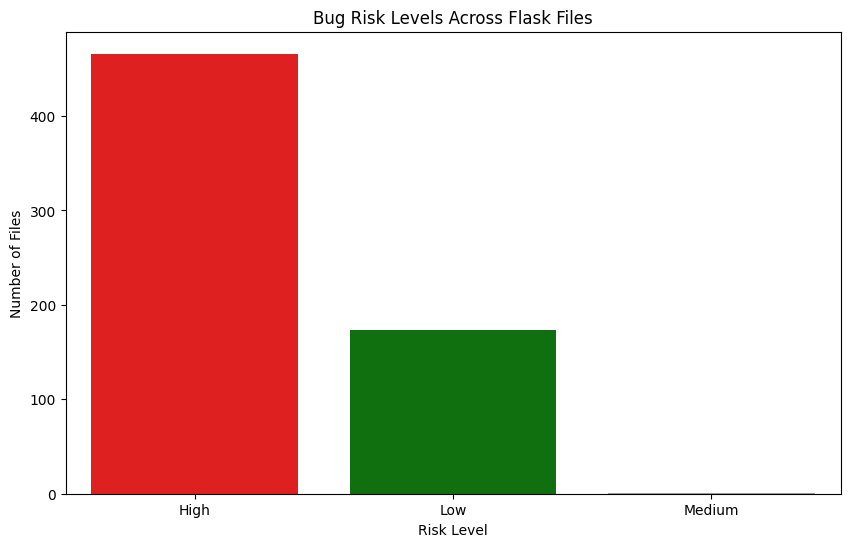

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.countplot(x='risk_level', data=agg_data, palette={'High':'red', 'Medium':'orange', 'Low':'green'})
plt.title('Bug Risk Levels Across Flask Files')
plt.xlabel('Risk Level')
plt.ylabel('Number of Files')
plt.show()


/tmp/ipython-input-4140803378.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


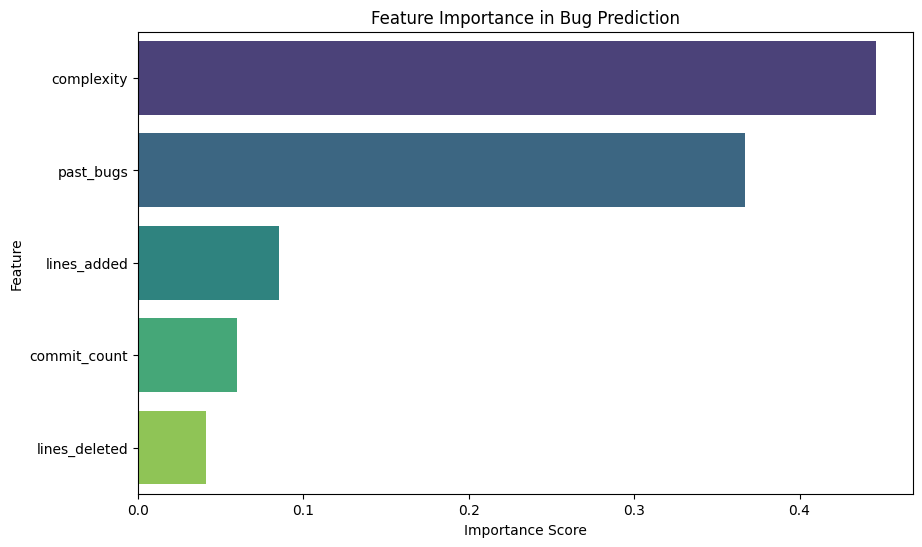

In [22]:
importances = rf.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance in Bug Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


In [23]:
top_files = agg_data.sort_values(by='risk_score_rf', ascending=False).head(20)
top_display = top_files[['filename', 'risk_score_rf', 'risk_level']]

def highlight_risk(val):
    color = {'High': 'background-color: red; color: white',
             'Medium': 'background-color: orange; color: black',
             'Low': 'background-color: green; color: white'}
    return color.get(val, '')

top_display.style.applymap(highlight_risk, subset=['risk_level'])


/tmp/ipython-input-1036352341.py:10: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  top_display.style.applymap(highlight_risk, subset=['risk_level'])


,filename,risk_score_rf,risk_level
623,tests/test_user_error_handler.py,1.000000,High
622,tests/test_testing.py,1.000000,High
619,tests/test_signals.py,1.000000,High
616,tests/test_reqctx.py,1.000000,High
615,tests/test_regression.py,1.000000,High
614,tests/test_meta.py,1.000000,High
613,tests/test_logging.py,1.000000,High
611,tests/test_json.py,1.000000,High
610,tests/test_instance_config.py,1.000000,High
609,tests/test_import_migration.py,1.000000,High


In [24]:
!pip install shap


/tmp/ipython-input-3165945635.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, plot_type="bar")
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


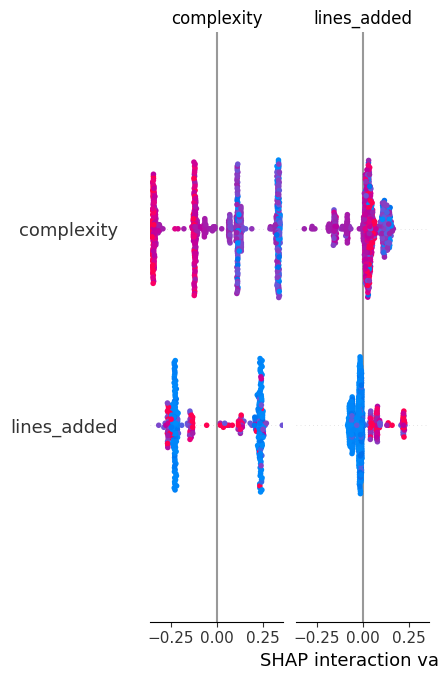

In [25]:
import shap

# Create SHAP explainer for Random Forest
explainer = shap.Explainer(rf, X)
shap_values = explainer(X)

# Summary plot
shap.summary_plot(shap_values, X, plot_type="bar")


In [27]:
import joblib

joblib.dump(rf, 'smart_bug_rf.pkl')
joblib.dump(lgbm, 'smart_bug_lgbm.pkl')


['smart_bug_lgbm.pkl']